In [1]:
import json
import math
from pathlib import Path

import geopandas as gpd
import pandas as pd
import seaborn as sns
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import shapely
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon
import rasterio.features

In [2]:
OUTPUT_DIR = Path("/Users/davidevans/code/drew-analysis/fields/")
OUTPUT_DIR.mkdir(exist_ok=True)

DATA_DIR = Path("/Users/davidevans/data/drew")

EPSG_CRS = "EPSG:32616"
field_boundaries = {
    "north-of-road": gpd.read_file('/Users/davidevans/data/drew/field-boundaries/north-of-road/boundaries.shp').to_crs(EPSG_CRS),
    "south-of-road": gpd.read_file('/Users/davidevans/data/drew/field-boundaries/south-of-road/boundaries.shp').to_crs(EPSG_CRS),
    "railroad-pivot": gpd.read_file('/Users/davidevans/data/drew/field-boundaries/railroad-pivot/boundaries.shp').to_crs(EPSG_CRS)
}
pivot_boundaries = {
    "north-of-road": gpd.read_file('/Users/davidevans/data/drew/field-boundaries/north-of-road/pivot-bounds.shp').to_crs(EPSG_CRS),
    "south-of-road": gpd.read_file('/Users/davidevans/data/drew/field-boundaries/south-of-road/pivot-bounds.shp').to_crs(EPSG_CRS),
}
irrigation_boundaries = {
    "north-of-road": field_boundaries["north-of-road"].overlay(pivot_boundaries["north-of-road"], how='intersection'),
    "south-of-road": field_boundaries["south-of-road"].overlay(pivot_boundaries["south-of-road"], how='intersection'),
}
soil_dfs = {
    "north-of-road": gpd.read_file('/Users/davidevans/data/drew/2025/soil/NorthField_SoilNutrientMaps.shp').to_crs(EPSG_CRS),
    "south-of-road": gpd.read_file('/Users/davidevans/data/drew/2025/soil/SouthField_SoilNutrientMaps.shp').to_crs(EPSG_CRS),
}

In [3]:
widths = {}
heights = {}
transforms = {}
for field_name, field_boundary in field_boundaries.items():
    pixel_size = 1
    xmin, ymin, xmax, ymax = field_boundary.total_bounds
    width = int((xmax - xmin) / pixel_size)
    height = int((ymax - ymin) / pixel_size)
    transform = rasterio.transform.from_origin(xmin, ymax, pixel_size, pixel_size)
    widths[field_name] = width
    heights[field_name] = height
    transforms[field_name] = transform

In [4]:
yield_rasters = {}

In [5]:
def create_yield_target_from_field_and_irrigation(field_boundary, irrigation_boundary, transform, height, width):
    field_boundary_geometry = field_boundary.geometry.iloc[0]
    irrigation_boundary_geometry = irrigation_boundary.geometry.iloc[0]

    # outer_irrigation_buffer_bounds = pivot_boundary.buffer(1.5)   # expand by 1.5m outward
    # inner_irrigation_buffer_bounds = pivot_boundary.buffer(-1.5)  # contract by 1.5m inward
    # irrigation_buffer_poly = field_boundary.intersection(outer_irrigation_buffer_bounds.difference(inner_irrigation_buffer_bounds))
    # irrigation_buffer_geometry = irrigation_buffer_poly.geometry.iloc[0]
    # yield_shapes = [(field_boundary_geometry, 175.0), (irrigation_boundary_geometry, 240.0), (irrigation_buffer_geometry, 0)]

    yield_shapes = [(field_boundary_geometry, 175.0), (irrigation_boundary_geometry, 240.0)]
    yield_raster = rasterio.features.rasterize(
        yield_shapes,
        out_shape=(height, width),
        transform=transform,
        fill=np.nan,
    )
    return yield_raster

# North and South of Road

## Define a yield target

In [6]:
for field_name in irrigation_boundaries.keys():
    yield_rasters[field_name] = create_yield_target_from_field_and_irrigation(field_boundaries[field_name ], irrigation_boundaries[field_name], transforms[field_name], heights[field_name], widths[field_name])

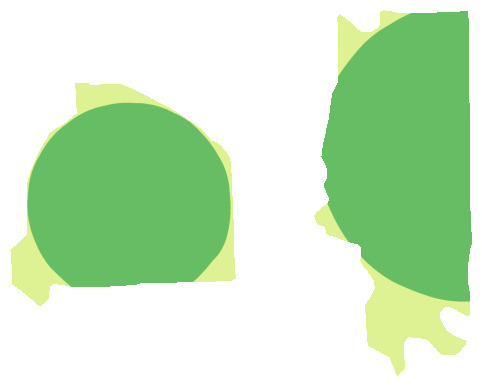

In [7]:
fig, ax = plt.subplots(1, len(irrigation_boundaries))
for idx, field_name in enumerate(irrigation_boundaries.keys()):
    ax[idx].imshow(yield_rasters[field_name], cmap='RdYlGn', vmin=0, vmax=300)
    ax[idx].axis('off')

In [8]:
for field_name in irrigation_boundaries.keys():
    field_dir = OUTPUT_DIR / field_name
    field_dir.mkdir(exist_ok=True)
    with rasterio.open(
        field_dir / f"yield_target.tif",
        'w',
        driver='GTiff',
        height=yield_rasters[field_name].shape[0],
        width=yield_rasters[field_name].shape[1],
        count=1,                # number of bands
        dtype=yield_rasters[field_name].dtype,
        crs=EPSG_CRS,
        transform=transforms[field_name],
        compress='lzw'          # optional
    ) as dst:
        dst.write(yield_rasters[field_name], 1)

## Raster the soil nutrients

In [9]:
nutrients = ['Soil_P_lb_', 'Soil_K_lb_', 'Soil_pH__1', 'Soil_Ca_lb', 'Soil_CEC_m', 'Soil_Mg_lb']

In [10]:
def raster_soil_nutrients(field_boundary, soil_df, transform, height, width, nutrient):
    # The way we're going to do this is raster the soil nutrients onto a 1m grid.
    # We're going to do this with scipy's `griddata` function.
    # The way that works is:
    # * We take a grid of data with values (our soil sample grid)
    # * We take a grid of points (our 1m grid)
    # * We use `griddata` to interpolate the values from the soil sample grid to the 1m grid

    # First let's define the soil sample grid
    input_points = soil_df.geometry.tolist()
    input_coords = [(point.x, point.y) for point in input_points]
    input_values = soil_df[nutrient].tolist()

    # Then let's define the 1m grid
    rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    rows_and_cols = np.array([rows.flatten(), cols.flatten()])
    x_global, y_global = rasterio.transform.xy(transform, rows, cols)
    points_global = np.array([Point(x, y) for x, y in zip(x_global.flatten(), y_global.flatten())])    

    # Then let's mask out the points that are outside the field
    mask = shapely.contains(field_boundary.iloc[0].geometry, points_global)
    points_inside_field = points_global[mask]

    output_coords = [(point.x, point.y) for point in points_inside_field]

    # Now we can interpolate.
    # We're going to do both linear and nearest neighbor interpolation.
    # Linear is probably more accurate, but it returns NaN for points near the field boundary where it can't interpolate.
    linear_output_values = griddata(input_coords, input_values, output_coords, method='linear')
    nearest_output_values = griddata(input_coords, input_values, output_coords, method='nearest')

    # So we're going to try to use linear interpolation, but if it returns NaN, we'll use nearest neighbor.
    output_values = np.where(np.isnan(linear_output_values), nearest_output_values, linear_output_values)
    output_rows = rows_and_cols[0, mask]
    output_cols = rows_and_cols[1, mask]

    # And finally we can create a raster
    output_raster = np.full((height, width), np.nan)
    output_raster[output_rows, output_cols] = output_values

    return output_raster

In [11]:
nutrient_rasters = {}
for field_name in irrigation_boundaries.keys():
    nutrient_rasters[field_name] = {}
    

In [12]:
for field_name in irrigation_boundaries.keys():
    for nutrient in nutrients:
        nutrient_raster = raster_soil_nutrients(field_boundaries[field_name], soil_dfs[field_name], transforms[field_name], heights[field_name], widths[field_name], nutrient)
        nutrient_rasters[field_name][nutrient] = nutrient_raster
        field_dir = OUTPUT_DIR / field_name
        field_dir.mkdir(exist_ok=True)

        if nutrient == 'Soil_P_lb_':
            nutrient_filename = 'phosphorus.tif'
        elif nutrient == 'Soil_K_lb_':
            nutrient_filename = 'potassium.tif'
        elif nutrient == 'Soil_CEC_m': 
            nutrient_filename = 'cec.tif'
        elif nutrient == 'Soil_Mg_lb': 
            nutrient_filename = 'magnesium.tif'
        elif nutrient == 'Soil_pH__1': 
            nutrient_filename = 'pH.tif'
        elif nutrient == 'Soil_Ca_lb': 
            nutrient_filename = 'calcium.tif'
        else:
            raise ValueError(f"Unknown nutrient: {nutrient}")

        with rasterio.open(
            field_dir / nutrient_filename,
            'w',
            driver='GTiff',
            height=nutrient_raster.shape[0],
            width=nutrient_raster.shape[1],
            count=1,                # number of bands
            dtype=nutrient_raster.dtype,
            crs=EPSG_CRS,
            transform=transforms[field_name],
            compress='lzw'          # optional
        ) as dst:
            dst.write(nutrient_raster, 1)

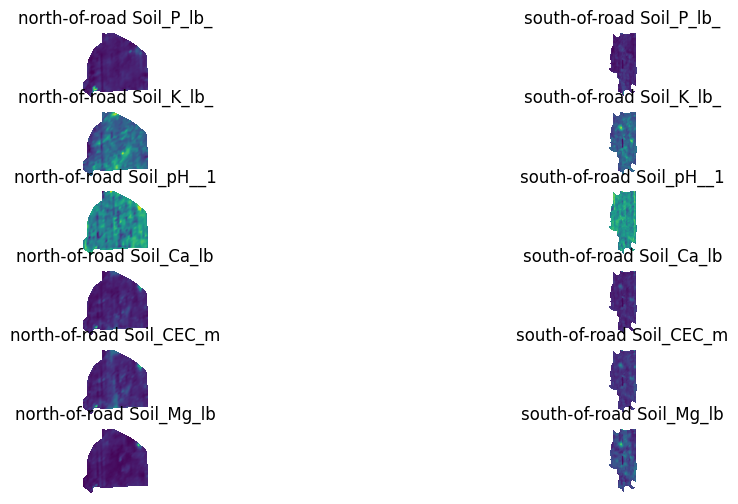

In [13]:
fig, ax = plt.subplots(len(nutrients), len(irrigation_boundaries.keys()), figsize=(12, 6))
for field_idx, field_name in enumerate(irrigation_boundaries.keys()):
    for nutrient_idx, nutrient in enumerate(nutrients):
        ax[nutrient_idx, field_idx].imshow(nutrient_rasters[field_name][nutrient])
        ax[nutrient_idx, field_idx].set_title(f"{field_name} {nutrient}")
        ax[nutrient_idx, field_idx].axis('off')
    

# Railroad Pivot

In [14]:
field_name = "railroad-pivot"

In [15]:
railroad_pivot_management_zones = gpd.read_file("/Users/davidevans/data/drew/field-boundaries/railroad-pivot/management-zones-saved.shp").to_crs(EPSG_CRS)

## Define a yield goal

In [16]:
# Load all the harvest data
all_harvest_data = []
for year in DATA_DIR.iterdir():
    if not year.is_dir():
        continue

    harvest_dir = DATA_DIR / year / "harvest"

    for harvest_json_path in harvest_dir.glob("*.json"):
        with open(harvest_json_path, "r") as f:
            harvest_json_data = json.load(f)

        if harvest_json_data['FieldName'] != 'RailRoad Pivot':
            continue

        shp_file_path = harvest_json_path.parent / (harvest_json_path.stem[:-15] + ".shp")
        harvest_data = gpd.read_file(shp_file_path)
        harvest_data['acres_covered'] = (harvest_data['SWATHWIDTH'] * harvest_data['DISTANCE']) * 0.0929 / 4046.86

        all_harvest_data.append(harvest_data)

harvest_df = pd.concat(all_harvest_data)

In [17]:
harvest_df = harvest_df[harvest_df['Crop'] == 173] 
# Extract the harvest year 
harvest_df['Time'] = pd.to_datetime(harvest_df['Time'])
harvest_df['year'] = harvest_df.Time.dt.year
# `VRYIELDVOL` is the average yield per acre. Let's determine the actual yield in the unit area of this datapoint.
harvest_df['yield_per_area'] = harvest_df['VRYIELDVOL'] * harvest_df['acres_covered']
# Any yield above 350 is probably an erroneous reading from the harvester
harvest_df = harvest_df[harvest_df.VRYIELDVOL < 350]
# Convert all points to UTM
harvest_df = harvest_df.to_crs(EPSG_CRS)
# Lastly reset index
harvest_df.reset_index(inplace=True)

/var/folders/dp/w6hwqbns1270wd92prqdslpc0000gn/T/ipykernel_44812/319674764.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  harvest_df['Time'] = pd.to_datetime(harvest_df['Time'])


In [18]:
def create_footprint_polygon(row, width_buffer=0.2, distance_buffer=0.2):
    box_center = np.array([row.geometry.x, row.geometry.y])
    width_meters = row.SWATHWIDTH * 0.3048 + width_buffer
    distance_meters = row.DISTANCE * 0.3048 + distance_buffer

    # This is the angle of the footprint where + is CCW above x-axis.
    theta = math.radians(90 - row.Heading)
    cos_value, sin_value = math.cos(theta), math.sin(theta)
    hw, hh = width_meters / 2, distance_meters / 2

    # Top right, top left, bottom left, bottom right
    local_footprint_coords = np.array([[hh, hw],
                                       [-hh, hw],
                                       [-hh, -hw],
                                       [hh, -hw]])
    # Define teh roation matrix
    R = np.array([[cos_value, -sin_value],
                  [sin_value, cos_value]])
    rotated_coords = local_footprint_coords.dot(R.T)
    global_footprint_coords = rotated_coords + box_center 
    # Create polygon
    footprint_polygon = Polygon(global_footprint_coords)
    return footprint_polygon

In [19]:
harvest_df["footprint"] = harvest_df.apply(lambda row: create_footprint_polygon(row), axis=1)
harvest_df.sort_values(by="VRYIELDVOL", ascending=True, inplace=True)

year_rasters = []
for label, a_years_harvest_df in harvest_df.groupby('year'):
    print(label)
    a_years_harvest_shapes = [(geom, val) for geom, val in zip(a_years_harvest_df.footprint, a_years_harvest_df["VRYIELDVOL"])]
    harvest_raster = rasterio.features.rasterize(a_years_harvest_shapes, out_shape=(heights[field_name], widths[field_name]), transform=transforms[field_name], fill=np.nan)
    year_rasters.append(harvest_raster)


2020
2022
2023
2024
2025


In [20]:
stacked_years = np.stack(year_rasters, axis=2)
yield_rasters[field_name] = np.nanmean(stacked_years, axis=2)

/var/folders/dp/w6hwqbns1270wd92prqdslpc0000gn/T/ipykernel_44812/4012456214.py:2: RuntimeWarning: Mean of empty slice
  yield_rasters[field_name] = np.nanmean(stacked_years, axis=2)


(np.float64(-0.5), np.float64(1451.5), np.float64(1366.5), np.float64(-0.5))

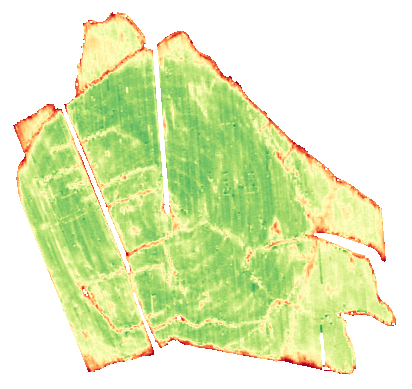

In [22]:
plt.imshow(yield_rasters[field_name], cmap='RdYlGn', vmin=0, vmax=300)
plt.axis('off')

In [23]:
field_dir = OUTPUT_DIR / field_name
field_dir.mkdir(exist_ok=True)
with rasterio.open(
    field_dir / f"yield_target.tif",
    'w',
    driver='GTiff',
    height=yield_rasters[field_name].shape[0],
    width=yield_rasters[field_name].shape[1],
    count=1,                # number of bands
    dtype=yield_rasters[field_name].dtype,
    crs=EPSG_CRS,
    transform=transforms[field_name],
    compress='lzw'          # optional
) as dst:
    dst.write(yield_rasters[field_name], 1)

## Raster soil data

In [24]:
soil_dfs[field_name] = pd.read_csv("/Users/davidevans/data/drew/2022/soil/railroad-pivot-soil-samples.csv")

In [25]:
soil_dfs['railroad-pivot']

,Sample ID,Lab Number,P lbs/A,K lbs/A,Mg lbs/A,Ca lbs/A,pH Soil,pH Buffer,Zn lbs/A,Mn lbs/A,CEC meq,K BS%,Mg BS%,Ca BS%,H BS %
0,1,749506CC,103,256,244,1204,6.3,7.80,4.9,42,6.0,5.5,17.1,50.5,26.9
1,2,749507CC,71,237,269,2047,6.6,7.80,4.4,41,8.1,3.7,13.8,62.9,19.7
2,3,749508CC,47,213,291,1425,5.9,7.70,4.3,65,7.4,3.7,16.3,47.8,32.2
3,4,749509CC,42,190,435,1827,6.7,7.85,3.2,43,7.8,3.1,23.2,58.4,15.3
4,5,749510CC,46,211,364,1587,6.4,7.75,4.1,46,7.8,3.5,19.6,51.2,25.8
5,6,749511CC,93,189,269,1256,6.7,7.85,4.0,37,5.7,4.2,19.7,55.1,21.0
6,7,749512CC,77,199,326,1594,6.8,7.85,3.9,38,6.8,3.8,20.0,58.6,17.7
7,8,749513CC,43,218,403,1907,6.5,7.75,2.9,44,8.7,3.2,19.2,54.6,22.9
8,9,749514CC,41,171,329,1646,6.3,7.80,3.6,41,7.3,3.0,18.8,56.3,21.9
9,10,749515CC,48,150,284,1537,6.2,7.75,4.3,45,7.2,2.7,16.4,53.2,27.7


In [ ]:
railroad_pivot_nutrients = ['P lbs/A', 'K lbs/A', 'Ca lbs/A', 'Mg lbs/A', 'ph Soil', 'CEC meq']
management_zone_nutrient_shapes = []

for zone_idx, management_zone in railroad_pivot_management_zones.iterrows():
    P_value = float(soil_dfs['railroad-pivot'].iloc[zone_idx]['P lbs/A'])
    K_value = float(soil_dfs['railroad-pivot'].iloc[zone_idx]['K lbs/A'])
    man
    management_zone_nutrient_shapes.append((management_zone.geometry, P_value, K_value))

103.0 256.0
71.0 237.0
47.0 213.0
42.0 190.0
46.0 211.0
93.0 189.0
77.0 199.0
43.0 218.0
41.0 171.0
48.0 150.0
55.0 197.0
61.0 168.0
53.0 219.0
82.0 254.0
72.0 198.0
42.0 186.0
53.0 196.0
70.0 268.0
42.0 190.0
93.0 189.0
77.0 199.0
72.0 198.0
53.0 196.0
53.0 196.0


In [27]:
nutrient_rasters[field_name] = {}

nutrient_rasters[field_name]['phosphorus'] = rasterio.features.rasterize(
    management_zone_P_shapes,
    out_shape=(heights[field_name], widths[field_name]),
    transform=transforms[field_name],
    fill=np.nan,
)
nutrient_rasters[field_name]['potassium'] = rasterio.features.rasterize(
    management_zone_K_shapes,
    out_shape=(heights[field_name], widths[field_name]),
    transform=transforms[field_name],
    fill=np.nan,
)

(np.float64(-0.5), np.float64(1451.5), np.float64(1366.5), np.float64(-0.5))

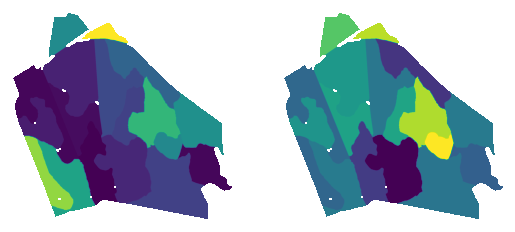

In [28]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(nutrient_rasters[field_name]['phosphorus'])
ax[0].axis('off')
ax[1].imshow(nutrient_rasters[field_name]['potassium'])
ax[1].axis('off')

In [29]:
for nutrient in nutrient_rasters[field_name].keys():
    nutrient_raster = nutrient_rasters[field_name][nutrient]
    field_dir = OUTPUT_DIR / field_name
    field_dir.mkdir(exist_ok=True)

    nutrient_filename = f'{nutrient}.tif'

    with rasterio.open(
        field_dir / nutrient_filename,
        'w',
        driver='GTiff',
        height=nutrient_raster.shape[0],
        width=nutrient_raster.shape[1],
        count=1,                # number of bands
        dtype=nutrient_raster.dtype,
        crs=EPSG_CRS,
        transform=transforms[field_name],
        compress='lzw'          # optional
    ) as dst:
        dst.write(nutrient_raster, 1)